# Chapter11 심층 신경망 훈련하기

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

- 심층 신경망 훈련 중에 일어날 문제들

 - 그레이디언트 소실/폭주

 - 훈련 데이터 부족 및 레이블을 만드는 작업 비용 부담

 - 급격히 줄어드는 훈련 속도

 - 훈련세트에 과대적합

### 11.1 그레이디언트 소실과 폭주 문제

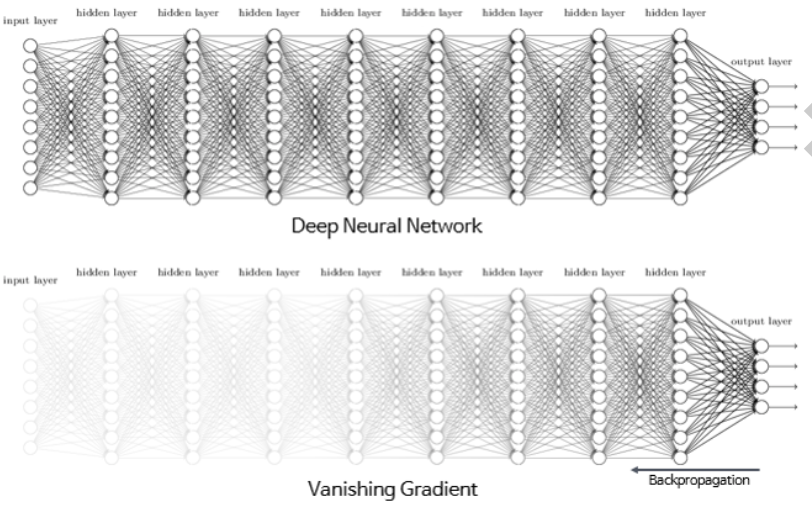

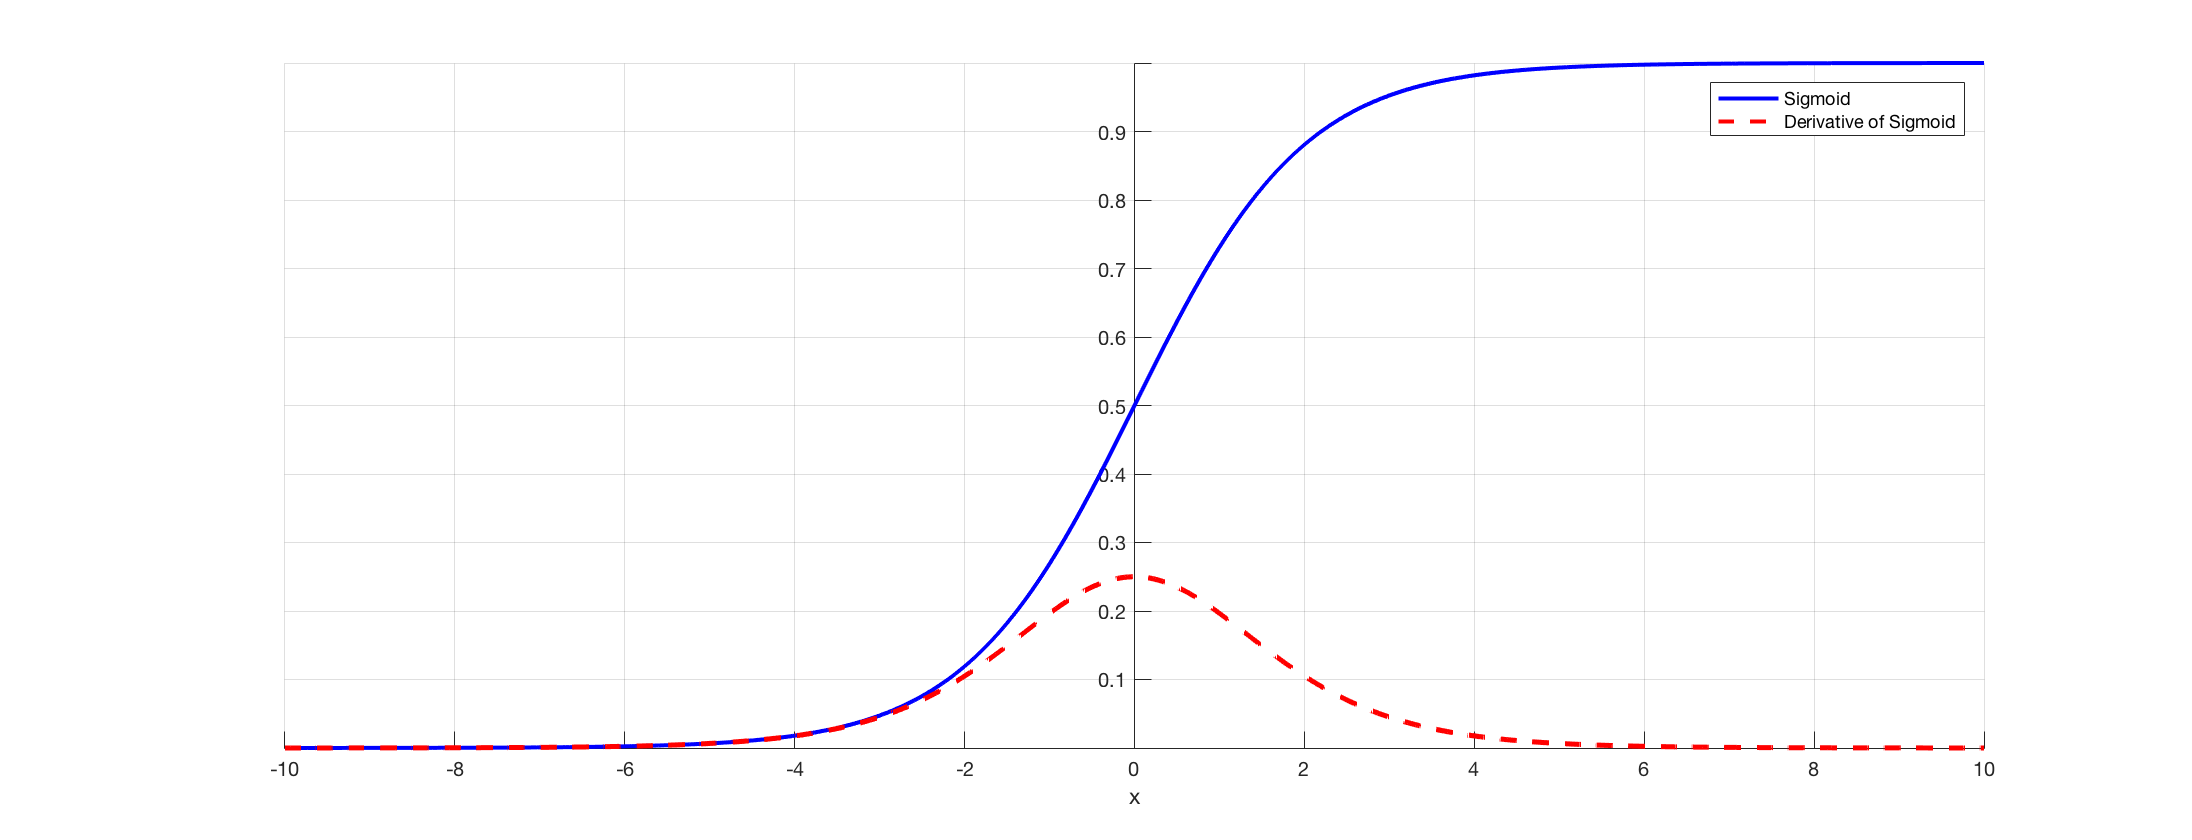

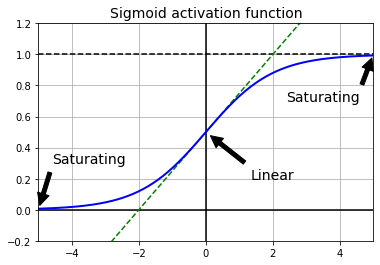

In [58]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

- 그레이디언트 소실 :

 시그모이드의 최댓값이 0.25이므로 신경망이 깊어질수록 gradient가 0에 가까워진다 (기울기 소실)

- 그레이디언트 폭주 :

 기울기가 점차 커지더니 가중치들이 비정상적으로 큰 값이 되면서 결국 발산

1. 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다.

2. 역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야 한다.

- Xavier 초깃값 (글로럿 초기화): 

 (S형 곡선의 활성화 함수)

 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포 사용

- He 초깃값 :
 
 (ReLU 함수와 그 변종들)

 앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$ 인 분포 사용

In [59]:
# 케라스는 기본적으로 글로럿 초기화를 사용
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')   # 층을 만들 때 매개변수 변경

In [60]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

ReLU 함수 (Rectified Linear Unit) :

특정 양숫값에 수렴하지 않는다는 큰 장점이 있다 (계산도 빠름)

그러나, 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다 (죽은 ReLU 문제)

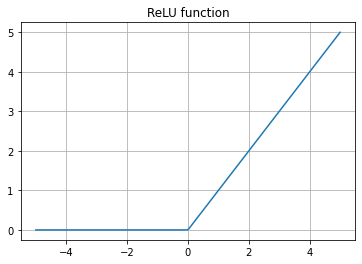

In [61]:
# ReLU 함수
def ReLU(x):
    return np.maximum(x,0)

y = ReLU(z)
plt.plot(z,y)
plt.grid('on')
plt.title('ReLU function')
plt.show()

ReLU 함수의 변종 (수렴하지 않는 활성화 함수) :

- LeakyReLU : max($\alpha z, z$)

 하이퍼파라미터 $\alpha$ : '새는$^{leaky}$ 정도' 를 결정, LeakyReLU를 절대 죽지 않게 만들어준다.

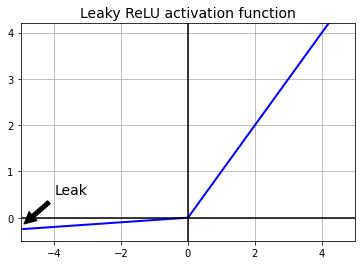

In [62]:
# LeakyReLU 함수
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

- ELU (Exponential Linear Unit) 함수 :

 $ELU_\alpha (z) = \Bigg\{ 
\begin{align}
\alpha & (exp(z)-1) \;\; & z < 0\\
z & &z > 0\\
\end{align}$

 z < 0 일 때 음숫값이 들어오므로, 활성화 함수의 평균 출력이 0에 더 가까워진다. --> 그레이디언트 소실 문제 완화

 z < 0 이어도 죽은 뉴런을 만들지 않는다.

 z = 0 일 때도 미분 가능

그러나, ReLU나 그 변종들보다 계산이 느리다. (지수 함수 계산 때문)

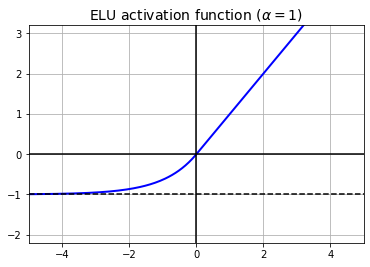

In [63]:
# ELU 함수

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

[Self-Normalizing Neural Networks](https://pod3275.github.io/paper/2019/03/27/SELU.html)

- SeLU 활성화 함수